![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench. If SeisBench is already installed on your machine, you can skip this.*

In [ ]:
!pip install seisbench

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [ ]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

# Training SeisDAE model

This tutorial shows how to train a model with SeisBench, using SeisDAE as an example. This tutorial has many lines of code in common with the tutorial how to train a PhaseNet model. However, training a denoising model requires different augmentation techniques.

*Note: As this tutorial brings together different parts of seisbench, it is recommended to go through the basic tutorials first before beginning this tutorial. In addition, this tutorial assumes some familiarity with pytorch*

In [1]:
import pathlib
import torch

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from scipy.signal import istft

import seisbench.data as sbd
import seisbench.models as sbm
import seisbench.generate as sbg
from seisbench.util import worker_seeding

from obspy.clients.fdsn import Client
from obspy import UTCDateTime

## Model and Data
We create a model for SeisDAE using ```seisbench.models```and loading the earthquake and noise data which are required for taining. If a GPU is available, the model is moved on the GPU to speedup training. Since the short-time Fourier transform is required (STFT), parameters for ```nfft``` and ```nperseg``` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html) are required.
Two different examples are given to train a new denoiser model with SeisDAE and one the continue training of DeepDenoiser model. The examples have the following parameters:
1. `nsamples=6000`, `nfft=99`, `nperseg=60` (SeisDAE)
1. `nsamples=3000`, `nfft=60`, `nperseg=30` (SeisDAE)
1. `nsamples=3000`, `nfft=60`, `nperseg=30` (DeepDenoiser)

In [2]:
# Values for 60 s @ 100 Hz sampling rate (only model SeisDAE)
#<nsamples = 6000
#nfft = 99
#nperseg = 60

# Values for 30 s @ 100 Hz sampling rate (models SeisDAE and DeepDenoiser)
nsamples = 3000
nfft = 60
nperseg = 30

# Set up model (SeisDAE)
model = sbm.SeisDAE(sampling_rate=100,
                    in_samples=nsamples,
                    nfft=nfft,
                    nperseg=nperseg)

# Set up model of DeepDenoiser to continue training of pretrained model
# model = sbm.DeepDenoiser.from_pretrained("original")

if torch.cuda.is_available():
    model.cuda()
    print("Running on GPU")
else:
    print("Running on CPU")

Running on CPU


In [3]:
# Load datasets
# XXX Change this to open datasets (e.g. eathquake use DummyDataset and create a new DummyNoiseDataset)
earthquake_dataset = sbd.WaveformDataset(path="/home/janis/data/sb_datasets/stead_denoiser_earthquakes",
                                         sampling_rate=100,
                                         component_order="ZNE")
noise_dataset = sbd.WaveformDataset(path="/home/janis/data/sb_datasets/stead_denoiser_noise",
                                    sampling_rate=100,
                                    component_order="ZNE")

# Split earthquake dataset into training, validation and testing
eq_train, eq_val, eq_test = earthquake_dataset.train_dev_test()

## Generator pipeline
STEAD contains labels for P- and S-arrivals (e.g., trace_p_arrival_sample). These arrival types are mapped to P and S using a dictionary.

In [4]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
}

Now we define two generators with identical augmentations, one for training, one for validation. The augmentations are:
1. Selection of a (long) window around a pick. This way, we ensure that out data always contains a pick.
1. Selection of a random window with the length of ```nsamples```.
1. A labeller to produce the masking functions for earthquake, noise and noisy waveforms. The labeller also normalizes the traces and can work either with a single component, e.g. Z, or with several components, e.g. ZNE.
1. A change of datatype to float32, as this is expected by the pytorch model.

In [5]:
train_generator = sbg.GenericGenerator(eq_train)
val_generator = sbg.GenericGenerator(eq_val)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()),
                           samples_before=int(0.8 * nsamples),
                           windowlen=int(1.5 * nsamples),
                           selection="first",
                           strategy="variable"),
    sbg.RandomWindow(windowlen=nsamples,
                     strategy="pad"),
    sbg.DenoiserLabeller(noise_dataset=noise_dataset,
                         nfft=nfft,
                         nperseg=nperseg,
                         scaling_type="peak",
                         component="Z"),
    sbg.ChangeDtype(np.float32),
]

train_generator.add_augmentations(augmentations=augmentations)
val_generator.add_augmentations(augmentations=augmentations)

Let's visualize a few training examples (real and imaginary part of noisy waveform (left) and mask functions for earthquake and noise (right)). Everytime you run the cell below, you'll see a different training example.

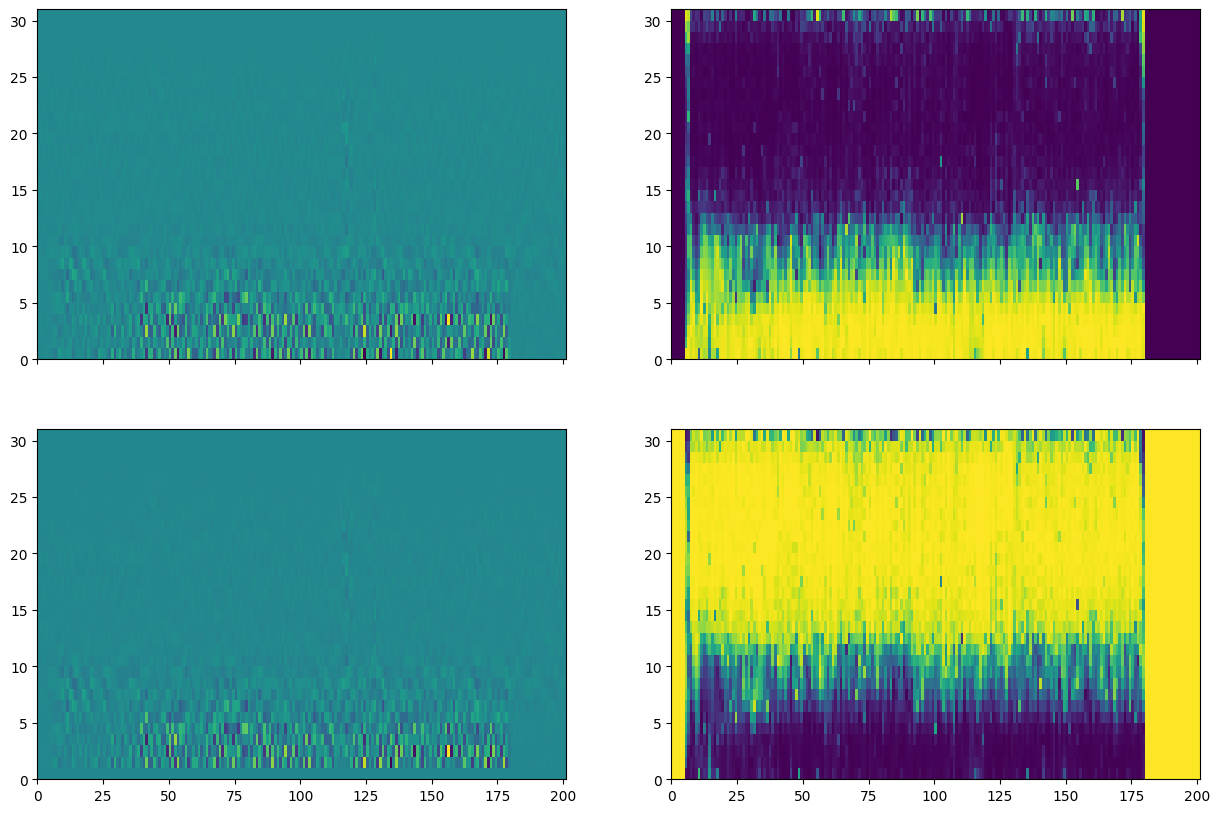

In [6]:
sample = train_generator[np.random.randint(len(train_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 2, sharex=True)
# Input of CNN
axs[0, 0].pcolormesh(sample["X"][0, :])  # Noisy real
axs[1, 0].pcolormesh(sample["X"][1, :])  # Noisy imag
# Output of CNN
axs[0, 1].pcolormesh(sample["y"][0, :])  # mask earthquake
axs[1, 1].pcolormesh(sample["y"][1, :])  # mask noise

SeisBench generators are pytorch datasets. Therefore, we can pass them to pytorch data loaders. These will automatically take care of parallel loading and batching. Here we create one loader for training and one for validation. We choose a batch size of 128 samples. This batch size is rather small due to the size of the model (1.3 M parameters) However, this should fit on most hardware.
*For training models on GPUs with larger datasets, we recommend a larger batch size (e.g. 512 or 1024). 

In [7]:
batch_size = 128
num_workers = 8  # The number of threads used for loading data

train_loader = DataLoader(dataset=train_generator,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers,
                          worker_init_fn=worker_seeding)
val_loader = DataLoader(dataset=val_generator,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers,
                        worker_init_fn=worker_seeding)

## Training a model
Now we got all components for training the model. What we still need to do is define the optimizer and the loss, and write the training and validation loops.

In [8]:
learning_rate = 1e-2
epochs = 5

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)
loss_fn = torch.nn.BCELoss()

In [9]:
def train_loop(dataloader):
    size = len(dataloader.dataset)
    for batch_id, batch in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(batch["X"].to(model.device))
        loss = loss_fn(input=pred.float(), 
                       target=batch["y"].to(model.device).float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader):
    num_batches = len(dataloader)
    test_loss = 0

    model.eval()  # close the model for evaluation

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(model.device))
            test_loss += loss_fn(input=pred.float(), 
                                 target=batch["y"].to(model.device).float())

    model.train()  # re-open model for training stage

    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader)
    test_loop(val_loader)

Epoch 1
-------------------------------
loss: 0.680779  [    0/ 4229]
loss: 0.648933  [  640/ 4229]
loss: 0.647787  [ 1280/ 4229]


## Saving the model
In case you would like to save your model, run the following code:

In [ ]:
model.save(path="./my_seisdae_model")

Later, you can load the model by calling `sbm.SeisDAE.load("./my_seisdae_model")`

## Evaluating the model

Now we can evaluate the trained model. In the first part, the STFT and masling functions are displayed. First, we will check how the model does work on an example from the validation set. Note that the model will most likely not be fully trained after only five epochs.

In [ ]:
sample = val_generator[np.random.randint(len(val_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 3, sharex=True)
axs[0, 0].pcolormesh(sample["X"][0, :])  # Noisy input real
axs[1, 0].pcolormesh(sample["X"][1, :])  # Noisy input imag

axs[0, 1].pcolormesh(sample["y"][0, :])  # Mask earthqauke
axs[1, 1].pcolormesh(sample["y"][1, :])  # Mask noise

model.eval()  # close the model for evaluation

with torch.no_grad():
    pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[0, 2].pcolormesh(pred[0, :])  # Predicted mask earthquake
axs[1, 2].pcolormesh(pred[1, :])  # Predicted mask noise

Instead of plotting STFT and masking functions, we will plot waveforms of noisy earthquake waveform, earthquake without noise and predicted denoised waveform, using the inverse short-time Fourier transform (ISTFT, https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.istft.html).

In [ ]:
stft_noisy = sample["X"][0, :] + 1j * sample["X"][1, :]
stft_earthquake_target = stft_noisy * sample["y"][0, :]
stft_noise_target = stft_noisy * sample["y"][1, :]
stft_earthquake_prediction = stft_noisy * pred[0, :]
stft_noise_prediction = stft_noisy * pred[1, :]

# Transform back into time domain
_, noisy_waveform = istft(Zxx=stft_noisy,
                          fs=100,
                          nfft=nfft,
                          nperseg=nperseg)
_, target_earthquake = istft(Zxx=stft_earthquake_target,
                             fs=100,
                             nfft=nfft,
                             nperseg=nperseg)
_, prediction_earthquake = istft(Zxx=stft_earthquake_prediction,
                                 fs=100,
                                 nfft=nfft,
                                 nperseg=nperseg)

# Plot earthquake waveforms of noisy, target earthquake and predicted earthquake
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, gridspec_kw={"hspace": 0, "height_ratios": [1, 1, 1]})
axs[0].plot(noisy_waveform)
axs[1].plot(target_earthquake)
axs[2].plot(prediction_earthquake)

As a second option, we'll directly apply our model to an obspy waveform stream using the `annotate` function. For this, we are downloading waveforms through FDSN and annotating them. Note that you could use the `classify` function in a similar fashion.

In [ ]:
client = Client("ETH")

t = UTCDateTime("2019-11-04T00:59:46.419800Z")
stream = client.get_waveforms(network="CH", 
                              station="EMING", 
                              location="*", 
                              channel="HHZ", 
                              starttime=t-30, 
                              endtime=t+50)

denoised = model.annotate(stream)

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharey=True, gridspec_kw={"hspace": 0, "height_ratios": [1, 1]})
axs[0].plot(stream[0].times(), stream[0].data, label=stream[0].stats.channel)
axs[1].plot(denoised[0].times(), denoised[0].data, label=denoised[0].stats.channel)

axs[0].legend()
axs[1].legend()

## Remarks
1. In case you get the Error `ValueError: If data with length ... are transformed with STFT and back transformed with ISTFT, the output lenght of ISTFT (...) does not match. Choose different values for nfft=... and nperseg=....` choose different values for STFT and ISTFT.
2. Since the approach assumes that the noisy signal is a superposition of noise and clean earthquake waveform, the amplitude of the denoised waveform is always smaller or equal to amplitude of the noisy waveform.